In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import networkx as nx


from netgraph import Graph, InteractiveGraph

from networkx.algorithms.community import girvan_newman, modularity_max, louvain_communities

from visu_utils import *

# white grid
sns.set_style("whitegrid")

%load_ext autoreload
%autoreload 2



In [2]:


PREFIX = "mteb_ds"
df = pd.read_csv('exported_data/normalized_13.df')

df = text_embeddings_metadata_results_preprocessing(df, models=MODELS_MAIN_EXPES)
METRIC = "I(X_1->X_2)/d_2"

table = make_table_pivot(METRIC, df)

METRICS = ['Average (56 datasets)', 'Classification Average (12 datasets)', 'Clustering Average (11 datasets)', 'Retrieval Average (15 datasets)', 'STS Average (10 datasets)', 'Reranking Average (4 datasets)']

mteb = pd.read_csv('exported_data/df_mteb_avg.csv')

import re

def extract_url_from_html_link(html):
    return re.findall(r'href=[\'"]?([^\'" >]+)', html)[0]

mteb['model'] = mteb['Model'].apply(extract_url_from_html_link).apply(lambda x: "/".join(x.split('/')[-2:]))
mteb['model'] = mteb['model'].apply(lambda x: x.split('/')[-1])


/home/mdarrin/Documents/phd/transformers/EMIRR/EMIR/nlp_embeddings/analysis/visu_utils.py:57: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  .pivot("model_1", "model_2", metric)


In [3]:

classifcation_df = pd.read_csv('exported_data/classification_many_3_avg.csv')

classifcation_df['model'] = classifcation_df['model'].apply(lambda x: eval(x)[0])

print(len(classifcation_df['dataset'].unique()))

classifcation_df = classifcation_df.groupby('model').mean().reset_index()

pivoted_classif = classifcation_df[['model','success']].set_index('model') # .pivot_table(index='model', columns='dataset', values='success')

pivoted_classif = pivoted_classif.rename(columns={'success': 'Classification 2 (8 datasets)'})
pivoted_classif.index = pivoted_classif.index.map(lambda x: x.split('/')[-1])


perfs = pd.merge(mteb, pivoted_classif, on='model').set_index('model')[METRICS+['Classification 2 (8 datasets)']]


9


/tmp/ipykernel_598255/2388912144.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classifcation_df = classifcation_df.groupby('model').mean().reset_index()


In [73]:

N_sample = 100
model_list = table.index


correlations = []
for n_models in range(2, 30):
    for _ in range(N_sample):
        models = np.random.choice(model_list, n_models, replace=False)
        table_= table.loc[models, models]
        
        info = table_.median(axis=1).to_frame().reset_index().rename(columns={'model_1': 'model', 0:METRIC}).set_index('model')
        info.index = info.index.map(lambda x: x.split('/')[-1])
        pearson = info.join(perfs, how='inner').corr(method="pearson").loc[METRICS, METRIC].rename('Pearson')
        spearman = info.join(perfs, how='inner').corr(method='spearman').loc[METRICS, METRIC].rename('Spearman')
        kendall = info.join(perfs, how='inner').corr(method='kendall').loc[METRICS, METRIC].rename('Kendall-Tau')
        _df = pd.concat([pearson, spearman, kendall], axis=1)
        _df['N'] = n_models
        correlations.append(_df)

correlations = pd.concat(correlations).reset_index().rename(columns={'index': 'metric'})



In [74]:
correlations

,metric,Pearson,Spearman,Kendall-Tau,N
0,Average (56 datasets),1.000000,1.000000,1.000000,2
1,Classification Average (12 datasets),1.000000,1.000000,1.000000,2
2,Clustering Average (11 datasets),1.000000,1.000000,1.000000,2
3,Retrieval Average (15 datasets),1.000000,1.000000,1.000000,2
4,STS Average (10 datasets),1.000000,1.000000,1.000000,2
...,...,...,...,...,...
16795,Classification Average (12 datasets),0.899470,0.816252,0.699143,29
16796,Clustering Average (11 datasets),0.829132,0.813130,0.657143,29
16797,Retrieval Average (15 datasets),0.880558,0.875420,0.691429,29
16798,STS Average (10 datasets),0.888639,0.711145,0.554286,29


In [75]:

pivot_correlations = correlations.melt(id_vars=['metric', 'N'], value_vars=['Pearson', 'Spearman', 'Kendall-Tau'], var_name='Type', value_name='Correlation').reset_index()
pivot_correlations = pivot_correlations.rename(columns={'metric': 'Metric'})

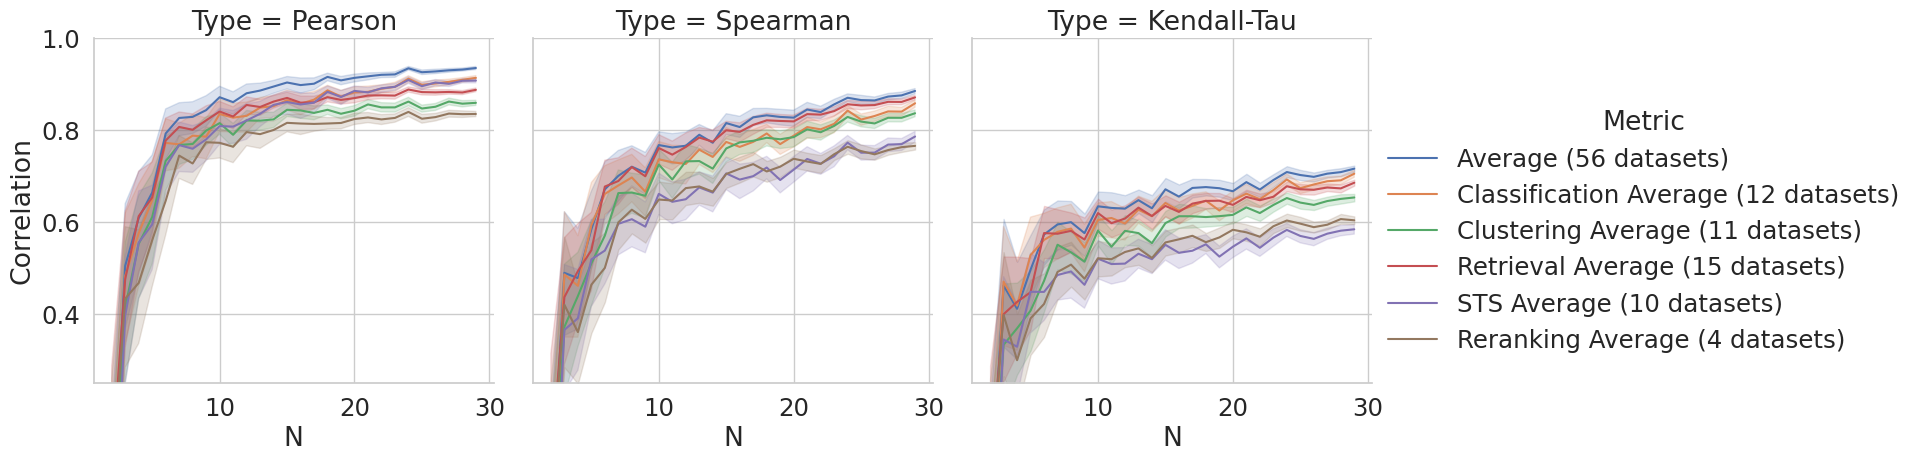

In [83]:

# whitegrid
sns.set_style("whitegrid")

g = sns.relplot(data=pivot_correlations, x='N', y='Correlation', col='Type', hue='Metric', kind='line', height=5, aspect=1)

# make ylim
g.set(ylim=(0.25, 1))

# make text scale bigger
sns.set(font_scale=1.6)

path = Path(f"../../../papers/emir-embedding-comparison/fig/nlp/{PREFIX}_impact_number_of_models.pdf")
# make sure the folder exists
path.parent.mkdir(parents=True, exist_ok=True)
# fig.tight_layout()
g.fig.savefig(path, bbox_inches='tight', dpi=300)


# Correlation heatmap model / metrics